In [18]:
# load Libarary
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import folium
import osmnx as ox
from deap import base, creator, tools, algorithms
from math import radians, sin, cos, sqrt, atan2


# Menghapus kelas jika sudah ada
if hasattr(creator, "FitnessMin"):
    del creator.FitnessMin
if hasattr(creator, "Individual"):
    del creator.Individual

# Fungsi untuk menghitung jarak antar titik
def calculate_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Data koordinat titik distribusi di Aceh
locations = {
    "Banda Aceh": (5.5483, 95.3238),
    "Sabang": (5.8930, 95.3214),
    "Langsa": (4.4680, 97.9688),
    "Lhokseumawe": (5.1826, 97.1443),
    "Meulaboh": (4.1442, 96.1269),
    "Takengon": (4.6342, 96.8416)
}

points = list(locations.values())
location_names = list(locations.keys())

# Matriks jarak
distance_matrix = [[calculate_distance(p1, p2) for p2 in points] for p1 in points]

# Inisialisasi DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(points)), len(points))
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual):
    distance = 0
    for i in range(len(individual) - 1):
        distance += distance_matrix[individual[i]][individual[i+1]]
    distance += distance_matrix[individual[-1]][individual[0]]  # Kembali ke titik awal
    return distance,

toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Parameter GA
population_size = 100
crossover_prob = 0.8
mutation_prob = 0.2
num_generations = 500

# Inisialisasi populasi
population = toolbox.population(n=population_size)

# Log proses iterasi
log = []

# Algoritma evolusi
for gen in range(num_generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

    # Logging
    fits = [ind.fitness.values[0] for ind in population]
    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5

    log.append(f"Gen: {gen}, Min: {min(fits)}, Max: {max(fits)}, Avg: {mean}, Std: {std}")

# Menemukan solusi terbaik
best_individual = tools.selBest(population, k=1)[0]
best_distance = evaluate(best_individual)[0]

best_route = [location_names[i] for i in best_individual]

best_route



['Banda Aceh', 'Sabang', 'Lhokseumawe', 'Langsa', 'Takengon', 'Meulaboh']

In [19]:
# Menampilkan hasil
df = pd.DataFrame({
    "Route Order": range(1, len(best_route) + 1),
    "Location": best_route
})

print(df)
print("Jarak terpendek:", best_distance)



   Route Order     Location
0            1   Banda Aceh
1            2       Sabang
2            3  Lhokseumawe
3            4       Langsa
4            5     Takengon
5            6     Meulaboh
Jarak terpendek: 7.015699920239235


In [20]:
# Mencetak log proses iterasi
for entry in log:
    print(entry)



Gen: 0, Min: 7.015699920239235, Max: 11.007279174769817, Avg: 8.26250257436297, Std: 1.0251964083399048
Gen: 1, Min: 7.015699920239236, Max: 10.414106087173321, Avg: 7.597952046342598, Std: 0.610263561785455
Gen: 2, Min: 7.015699920239235, Max: 10.9512314494296, Avg: 7.472585728424715, Std: 0.5184147368035467
Gen: 3, Min: 7.015699920239235, Max: 9.1258265474411, Avg: 7.271864716368342, Std: 0.3179570956719026
Gen: 4, Min: 7.015699920239235, Max: 7.629523686970483, Avg: 7.1191401410754676, Std: 0.178033034555496
Gen: 5, Min: 7.015699920239235, Max: 8.617926578025413, Avg: 7.099682607934124, Std: 0.217376748035673
Gen: 6, Min: 7.015699920239235, Max: 7.620193398724059, Avg: 7.072532024242714, Std: 0.14666518065569306
Gen: 7, Min: 7.015699920239235, Max: 7.620193398724059, Avg: 7.04887508029188, Std: 0.1072743068763732
Gen: 8, Min: 7.015699920239235, Max: 7.554617553514487, Avg: 7.023171852727107, Std: 0.05729118343519726
Gen: 9, Min: 7.015699920239235, Max: 7.015699920239235, Avg: 7.0156

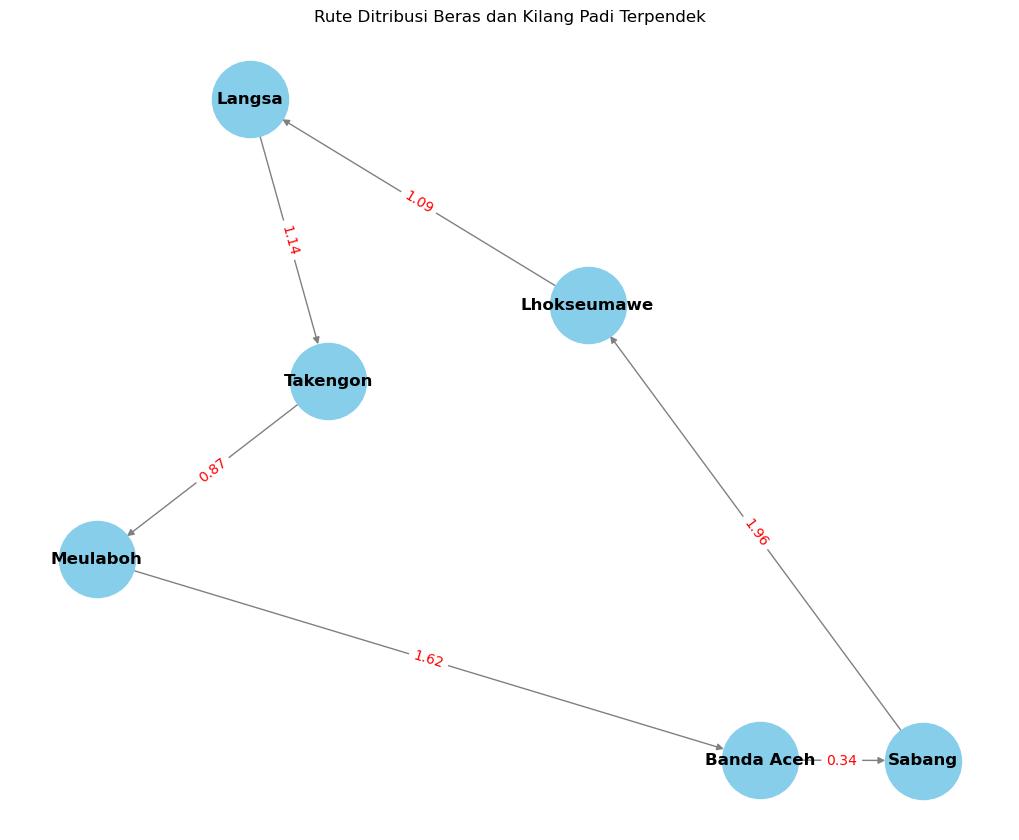

In [21]:
# Visualisasi grafik Pemetaan
G = nx.DiGraph()
for i in range(len(best_individual) - 1):
    G.add_edge(best_individual[i], best_individual[i + 1], weight=distance_matrix[best_individual[i]][best_individual[i + 1]])
G.add_edge(best_individual[-1], best_individual[0], weight=distance_matrix[best_individual[-1]][best_individual[0]])

pos = {i: points[i] for i in range(len(points))}
labels = {i: location_names[i] for i in range(len(points))}

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', edge_color='gray')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}, font_color='red')
plt.title("Rute Ditribusi Beras dan Kilang Padi Terpendek")
plt.show()

In [25]:
# Fungsi untuk menghitung jarak Haversine antar titik
def haversine(coord1, coord2):
    R = 6371.0  # Radius bumi dalam kilometer
    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    distance = R * c
    return distance

# Visualisasi peta menggunakan Folium
m = folium.Map(location=[5.5483, 95.3238], zoom_start=8)

# Menambahkan titik lokasi
for location, coord in locations.items():
    folium.Marker(location=coord, popup=location).add_to(m)

# Menambahkan garis rute dengan jarak
route_coords = [points[i] for i in best_individual] + [points[best_individual[0]]]
for i in range(len(route_coords) - 1):
    start = route_coords[i]
    end = route_coords[i + 1]
    distance = haversine(start, end)
    folium.PolyLine(locations=[start, end], color='blue', tooltip=f'{distance:.2f} km').add_to(m)

# Menyimpan peta ke file HTML
m.save("optimal_distribution_route.html")

# Menampilkan peta di notebook (jika menggunakan Jupyter Notebook)
m